# SVM Model for Tumour Classification
## B. Multiclass task
### Build a classifier to identify the type of tumor in each MRI image (meningioma tu-
### mor, glioma tumor, pituitary tumor or no tumor).

Import necessary libraries, matplotlib, pandas, numpy, sklearn, PIL, scipy and os module

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from scipy.stats import uniform
import pandas as pd
from PIL import Image                 #Import PIL for image size reduction
import os                             #Import os module for path operation
from os import path

Read label.csv; Define original/resized image data folder path

In [68]:
csv_array = pd.read_csv('./dataset/label.csv')

dir_image = "./dataset/image/"
dir_small_img = "./dataset/small_img/"
dir_img256 = "./dataset/image256/"

if path.exists(dir_small_img) == 'false':
    os.makedirs(dir_small_img)
if path.exists(dir_img256) == 'false':
    os.makedirs(dir_img256)

Resize 3000 images from 512512 to 256256 resolution; Read resized images into "imgs" array; each image is flattened into one row and also reduced from RGB to grey scale.

In [69]:
#rows, cols = (3000, 16384)             
rows, cols = (3000, 65536)            #rows is data set size; cols is width*length (after image size reduction. Here is 256*256)

imgs = np.zeros((rows,cols))

basewidth = 256                       #Target image width is 256; original width is 512
img = Image.open("./dataset/image/IMAGE_0000.jpg")
wpercent = float(basewidth) / float(img.size[0])       #use "256/512" as resize ratio (wpercent)
hsize = int((float(img.size[1]) * float(wpercent)))    #calculated target image height using resize ratio (wpercent)

for i in range(rows):                 #Reduce every image's size and save them in 'dir_img256' folder
    img = Image.open(dir_image + csv_array.file_name[i])
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    img.save(dir_img256 + csv_array.file_name[i])

for i in range(rows):                 #Read every resized image and reduce it from RGB to grayscale format. Transform it to 1-d array. Store all images in 2-d array imgs. 
    img = mpimg.imread(dir_img256 + csv_array.file_name[i])[...,0]
    imgs[i] = img.flatten()
print(imgs.shape)

(3000, 65536)


Extract maximum 3000 components; Check explained variance in order to choose a proper number of principle components

In [70]:
pca_3000 = PCA(n_components = 3000, random_state = 2020) 
pca_3000.fit(imgs)
imgs_pca_3000 = pca_3000.transform(imgs)

print("Variance explained by all 3000 principal components =", sum(pca_3000.explained_variance_ratio_ * 100))

Variance explained by all 3000 principal components = 100.00000000000007


Plot 'explained_variance_ratio' against 'number of priciple components'

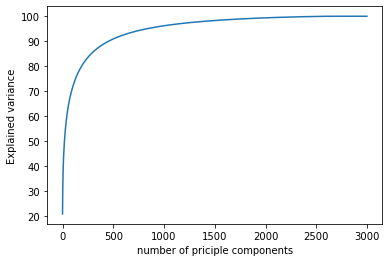

In [71]:
plt.plot(np.cumsum(pca_3000.explained_variance_ratio_ * 100))
plt.xlabel('number of priciple components')
plt.ylabel('Explained variance')
plt.savefig('BrainTumorPCA3000B.png',dpi = 100)

Find that 832 principle components reserved more than 95% of data variance

In [72]:
a = np.cumsum(pca_3000.explained_variance_ratio_ * 100)

threshold = 95
matched_index = np.where(a > threshold)[0][0]
print(f'matched_index: {matched_index}')
print(a[831])
print(a[832])

matched_index: 832
94.99376165347724
95.00201467265005


Extract 832 principle components which reserved more than 95% of data variance

In [73]:
pca_832 = PCA(n_components = 832, random_state = 2020)
pca_832.fit(imgs)
imgs_pca_832 = pca_832.transform(imgs)
print(imgs_pca_832.shape)

(3000, 832)


Split train/test data set by 9:1

In [74]:
x_train, x_test, y_train, y_test = train_test_split(imgs_pca_832, csv_array.label[0:rows], test_size=0.10, random_state=0)
print(x_train.shape)

(2700, 832)


Tune hyperparameter C for SVM model to get better classification accuracy

In [75]:
param_distributions = {"C": uniform(1, 99)} #Random tune C between 1 and 100

model = SVC(kernel='rbf', gamma='scale')
clf = RandomizedSearchCV(model, param_distributions, n_iter=25, random_state=42)
search = clf.fit(x_train[0:2700], y_train[0:2700])
search.best_estimator_

SVC(C=38.07947176588889)

Train SVM model (best_estimator_) and predict based on test data set. Print accuracy score.

In [76]:
search.best_estimator_.fit(x_train, y_train)
y_pred = search.best_estimator_.predict(x_test)
accuracy_score(y_test, y_pred)

0.9066666666666666